In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import torch_directml

In [2]:
print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # prefer gpu
# device = torch_directml.device()
print("Device", device)

Using torch 2.0.0+cu117
Device cpu


In [3]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1, device=device):
        """Make a random XOR data set.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.device = device
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)
        # Move data to GPU if relevant
        self.data = data.to(self.device)
        self.label = label.to(self.device)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def toNumpy(self):
        return (self.data.cpu().numpy(), self.label.cpu().numpy()) # must be on cpy to convert to numpy

Size of dataset: 200
Data point 0: (tensor([-0.1611,  0.4158]), tensor(0))


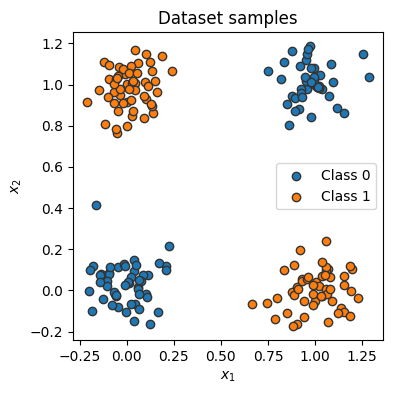

In [4]:
def visualize_binary_samples(dataset):
    """visualize a data set with binary labels.

    Args:
        data: the data set as, e.g., generated by XORDataset
    """
    (data,label) = dataset.toNumpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
visualize_binary_samples(dataset)
plt.show()

In [5]:
class SimpleClassifier(nn.Module):
    def __init__(self, src, tg, depth, width, device=device):
        """Make a convolutional neural network. Last layer uses the identity transfer function, the rest use the tanh.

        Args:
            src: The number of input nodes
            tg: The number of output nodes
            depth: The number of hidden layers
            width: The width of the hidden layers
        """
        super().__init__()

        self.enc_sizes = [src, tg, depth, width]


        ###############################################################################################
        # Assignment: replace self.model with your code for a network src-width-width-...-tg network
        ###############################################################################################
        layers = []
        
        if depth == 0:
            layers.append(nn.Linear(src, tg))
        else:
            layers.append(nn.Linear(src, width))
            layers.append(nn.Tanh())
            for _ in range(depth - 1):
                layers.append(nn.Linear(width, width))
                layers.append(nn.Tanh())
                
            layers.append(nn.Linear(width, tg))

        self.model = nn.Sequential(*layers)          

        # Move data to GPU if relevant
        self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(dim=1) # flat

        return x

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    """Train a model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        data_loader: The function to load the data
        loss_module: The function to evaluate the loss function
        num_epochs: The number of epochs to train
    """
    # Set model to train mode
    model.train()
    epoch_losses = [] 
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for data_inputs, data_labels in data_loader:
            # Step 1: Run the model on the input data
            preds = model(data_inputs)
            #preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 2: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 4: Update the parameters
            optimizer.step()
            
            total_loss += loss.item()
            
        epoch_loss = total_loss / len(data_loader)
        epoch_losses.append(epoch_loss)


def eval_model(model, data_loader, loss_module) -> tuple[float, list[float]]:
    """Evaluate a model.

    Args:
        model: A (trained) model
        data_loader: The function to load the data
    """
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0
    losses = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)

            losses.append(loss_module(preds, data_labels.float())) #record the loss

            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    mean_loss = torch.mean(torch.Tensor(losses))
    std_loss = torch.std(torch.Tensor(losses))
    acc = true_preds / num_preds
    return acc, mean_loss, std_loss

In [6]:
###############################################################################################
# Assignment: replace the following with code that trains your networks repeatedly on the same
# XORDataset for a range of depths and widths, e.g., depths and widths in the range range(4)
# and each repeated 3 times.
###############################################################################################
import wandb

# Initialize Weights and Biases
# wandb.init(project="xor-experiment", entity="your-username")


loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)


# Setup a feed-forward network with variable width
max_depth = 10
max_width = 10
depths, widths = range(max_depth), range(1, max_width + 1)
n_rep = 5
stds = np.zeros((max_depth, max_width))
losses = np.zeros((max_depth, max_width))
accs = np.zeros((max_depth, max_width))
for depth in depths:
    for width in widths:
        cum_std = 0.0
        cum_loss = 0.0
        cum_acc = 0.0
        for _ in range(n_rep):
            test_dataset = XORDataset(size=500)
            # drop_last -> Don't drop the last batch although it is smaller than 128
            test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
            model = SimpleClassifier(src=2, tg=1, depth=depth, width=width)
            # print(model)

            # Train
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            train_model(model, optimizer, train_data_loader, loss_module, num_epochs=200)

            # Evaluate
            acc, loss, std = eval_model(model, test_data_loader, loss_module)
            # print(f"Depth: {depth}, Width: {width}, Accuracy: {acc}, Loss: {loss}, Std: {std}")
            
            # Calculate mean and standard deviation of the resulting loss function
            cum_std += std
            cum_loss += loss
            cum_acc += acc
            
        print(f'---------- Depth: {depth}, Width: {width} --------------')
        print(f'mean loss: {cum_loss / n_rep}')
        print(f'mean std: {cum_std / n_rep}')
        print(f'mean acc: {cum_acc / n_rep}')
        
        stds[depth, width - 1] = cum_std / n_rep
        losses[depth, width - 1] = cum_loss / n_rep
        accs[depth, width - 1] = cum_acc / n_rep


---------- Depth: 0, Width: 1 --------------
mean loss: 0.6931036114692688
mean std: 0.0012573744170367718
mean acc: 0.4904000163078308
---------- Depth: 0, Width: 2 --------------
mean loss: 0.6944423913955688
mean std: 0.0017048775916919112
mean acc: 0.4700000286102295
---------- Depth: 0, Width: 3 --------------
mean loss: 0.6935492157936096
mean std: 0.0014304777141660452
mean acc: 0.4904000163078308
---------- Depth: 0, Width: 4 --------------
mean loss: 0.6926888227462769
mean std: 0.002074294025078416
mean acc: 0.49959999322891235
---------- Depth: 0, Width: 5 --------------
mean loss: 0.693691074848175
mean std: 0.002570301992818713
mean acc: 0.49119997024536133
---------- Depth: 0, Width: 6 --------------
mean loss: 0.6927970051765442
mean std: 0.0019423530902713537
mean acc: 0.5067999958992004
---------- Depth: 0, Width: 7 --------------
mean loss: 0.6927439570426941
mean std: 0.0019512695726007223
mean acc: 0.5224000215530396
---------- Depth: 0, Width: 8 --------------
mean

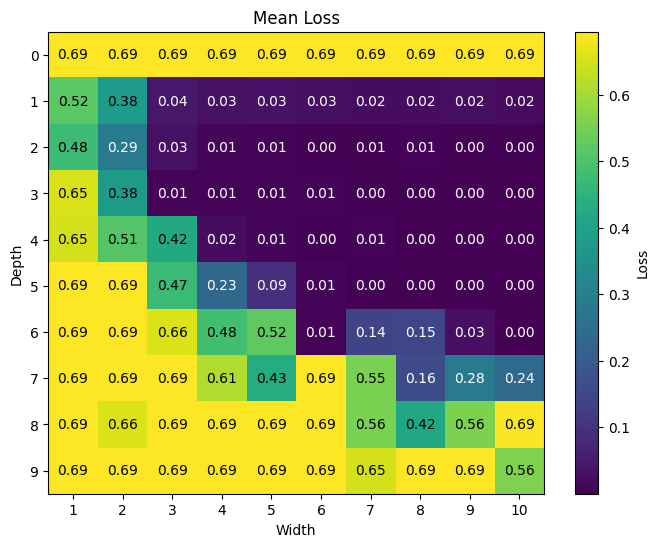

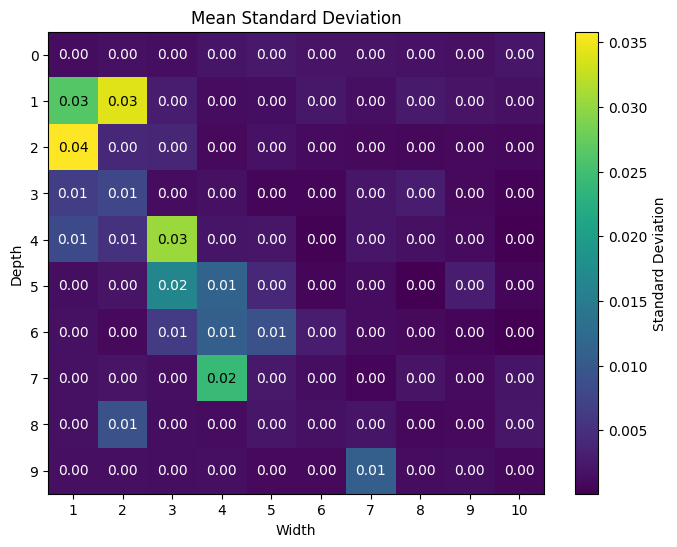

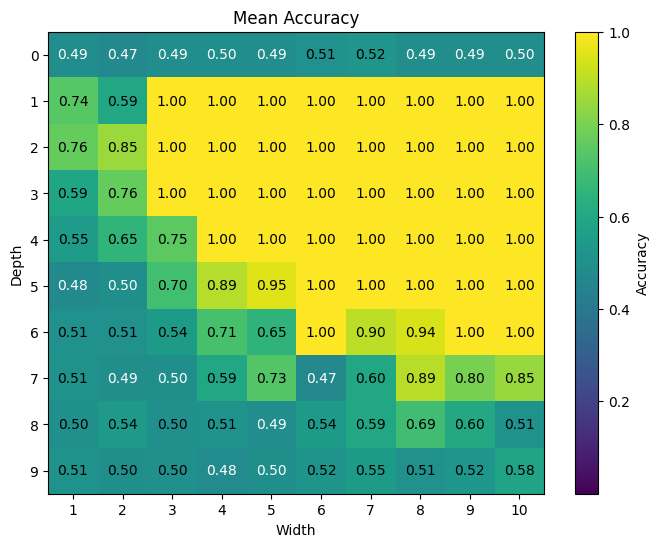

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data for the heatmap

def plot(heatmap_data, title='Heatmap', xlabel='Width', ylabel='Depth', cbar_label='Value'):
    # Create the heatmap plot
    plt.figure(figsize=(8, 6))
    
    cmap = plt.get_cmap('viridis')
    cmap.set_under('white')  # Set the under color to white for zero values
    heatmap = plt.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001)  # Adjust vmin to just above 0 to use 'under' color

    plt.colorbar(heatmap, label=cbar_label)
    plt.xticks(ticks=np.arange(len(widths)), labels=widths)
    plt.yticks(ticks=np.arange(len(depths)), labels=depths)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            plt.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='white' if heatmap_data[i, j] < (heatmap_data.max() / 2) else 'black')

    
    plt.show()

plot(losses, title='Mean Loss', cbar_label='Loss')
plot(stds, title='Mean Standard Deviation', cbar_label='Standard Deviation')
plot(accs, title='Mean Accuracy', cbar_label='Accuracy')